# 09 - RNN Sentiment Classification
Prepared by Jan Christian Blaise Cruz

DLSU Machine Learning Group

We'll continue our demos of recurrent neural networks by using them in another task: sentiment classification. We'll first show how to use LSTMs for sentiment classification, apply some techniques to improve performance, and use all of the techniques in our toolbox so far to make a robust classifier.

# Preliminaries

In [ ]:
!nvidia-smi

Tue Aug 25 11:19:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We'll download the iMDB sentiment dataset.

In [ ]:
!wget https://s3.us-east-2.amazonaws.com/blaisecruz.com/datasets/imdb/imdb.zip
!unzip imdb.zip && rm imdb.zip

Standard imports.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data_utils

import numpy as np
import pandas as pd
from tqdm import tqdm

import spacy
en = spacy.load('en')

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preprocessing

Load and shuffle the dataset.

In [ ]:
df = pd.read_csv('imdb/train.csv').sample(frac=1.0, random_state=42)
text, labels = list(df['text']), list(df['sentiment'])

Here's the first example.

In [ ]:
text[0]

"Great little thriller. I was expecting some type of silly horror movie but what I got was tight short thriller that waste none of our time. Mostof these movies we have to get into the back characters stories so we will either feel sympathy for them or hatred when people start getting killed. o such foolishness here. Yes you see a few characters but they really only interact with the principals. Such as the husband wife at the motel whose room was canceled. We saw them so we could just how efficient the Lisa character was and how inefficient the new Hotel clerk was. We see the little girl simply because she will have a very small but important role later in the movie when all heck breaks loose. THe Flight Atrendants because we need on in particular to move the plot ahead. The bad guy in particular needs her in the beginning of the flight. The rude guy in the airport was important to the movie too. The only 2 characters that were just 5 liners with no use to the plot were the two young 

We'll code up a tokenization function using Spacy. You may use your own here, but for the purpose of demonstration, we'll use a pretrained tokenizer.

In [ ]:
def tokenize(t): return [str(token) for token in en(t)]

This next cell takes about 20 minutes to process, so to save time, we'll load a pre-tokenized version of the dataset.

In [ ]:
#text = [tokenize(t) for t in tqdm(text)]
#with open('tokenized.pt', 'wb') as f:
#    torch.save([text], f)

Download the tokenized version.

In [ ]:
#!wget https://s3.us-east-2.amazonaws.com/blaisecruz.com/datasets/imdb/tokenized.pt

Then load it.

In [ ]:
with open('tokenized.pt', 'rb') as f:
    text = torch.load(f)[0]

Here's the first review in tokenized form.

In [ ]:
print(text[0])

['Great', 'little', 'thriller', '.', 'I', 'was', 'expecting', 'some', 'type', 'of', 'silly', 'horror', 'movie', 'but', 'what', 'I', 'got', 'was', 'tight', 'short', 'thriller', 'that', 'waste', 'none', 'of', 'our', 'time', '.', 'Mostof', 'these', 'movies', 'we', 'have', 'to', 'get', 'into', 'the', 'back', 'characters', 'stories', 'so', 'we', 'will', 'either', 'feel', 'sympathy', 'for', 'them', 'or', 'hatred', 'when', 'people', 'start', 'getting', 'killed', '.', 'o', 'such', 'foolishness', 'here', '.', 'Yes', 'you', 'see', 'a', 'few', 'characters', 'but', 'they', 'really', 'only', 'interact', 'with', 'the', 'principals', '.', 'Such', 'as', 'the', 'husband', 'wife', 'at', 'the', 'motel', 'whose', 'room', 'was', 'canceled', '.', 'We', 'saw', 'them', 'so', 'we', 'could', 'just', 'how', 'efficient', 'the', 'Lisa', 'character', 'was', 'and', 'how', 'inefficient', 'the', 'new', 'Hotel', 'clerk', 'was', '.', 'We', 'see', 'the', 'little', 'girl', 'simply', 'because', 'she', 'will', 'have', 'a', 

We'll remove capitalization to reduce the vocabulary and prevent our weights from being too sparse. To prevent loss of information, we'll add special tokens to denote capitalization instead.

We will also trim and pad our sequences to a specific **Maximum Sequence Length** (MSL). Unlike in language modeling, we will actually batch our samples, and they will have to be of same lengths.

In [ ]:
def process(line, msl):
    # Process each character
    temp = []
    for token in line:
        if token.isupper():
            temp.append('<cap>')
        elif token[0].isupper():
            temp.append('<maj>')
        temp.append(token.lower())
    temp.append('<eos>')

    # Pad/trim to MSL
    temp = temp[:msl]
    if len(temp) < msl:
        temp += ['<pad>' for _ in range(msl - len(temp))]
    
    return temp

Here's an example.

In [ ]:
print(process(text[0], msl=512))

['<maj>', 'great', 'little', 'thriller', '.', '<cap>', 'i', 'was', 'expecting', 'some', 'type', 'of', 'silly', 'horror', 'movie', 'but', 'what', '<cap>', 'i', 'got', 'was', 'tight', 'short', 'thriller', 'that', 'waste', 'none', 'of', 'our', 'time', '.', '<maj>', 'mostof', 'these', 'movies', 'we', 'have', 'to', 'get', 'into', 'the', 'back', 'characters', 'stories', 'so', 'we', 'will', 'either', 'feel', 'sympathy', 'for', 'them', 'or', 'hatred', 'when', 'people', 'start', 'getting', 'killed', '.', 'o', 'such', 'foolishness', 'here', '.', '<maj>', 'yes', 'you', 'see', 'a', 'few', 'characters', 'but', 'they', 'really', 'only', 'interact', 'with', 'the', 'principals', '.', '<maj>', 'such', 'as', 'the', 'husband', 'wife', 'at', 'the', 'motel', 'whose', 'room', 'was', 'canceled', '.', '<maj>', 'we', 'saw', 'them', 'so', 'we', 'could', 'just', 'how', 'efficient', 'the', '<maj>', 'lisa', 'character', 'was', 'and', 'how', 'inefficient', 'the', 'new', '<maj>', 'hotel', 'clerk', 'was', '.', '<maj>

We'll limit the length of the reviews to the median length of the entire dataset.

In [ ]:
med_msl = int(np.median([len(line) for line in text]))
print(med_msl)

204


Process the entire dataset.

In [ ]:
text = [process(line, msl=med_msl) for line in tqdm(text)]

100%|██████████| 25000/25000 [00:02<00:00, 11654.02it/s]


Then split in to training and validation sets.

In [ ]:
tr_sz = int(len(text) * 0.7) 

X_train, y_train = text[:tr_sz], labels[:tr_sz]
X_valid, y_valid = text[tr_sz:], labels[tr_sz:]

Here's the sizes of our data.

In [ ]:
len(X_train), len(X_valid)

(17500, 7500)

Next, we'll build a vocabulary.

In [ ]:
idx2word = ['<unk>', '<pad>', '<maj>', '<cap>', '<eos>']
for line in X_train: idx2word.extend(line)
vocab_set = set(idx2word)
idx2word = list(vocab_set)

word2idx = {idx2word[i]: i for i in range(len(idx2word))}

Check the number of tokens in the vocab set.

In [ ]:
len(vocab_set)

56108

Then convert all tokens in the validation set that aren't present in the vocabulary into unknown tokens.

In [ ]:
X_valid = [[token if token in vocab_set else '<unk>' for token in line] for line in tqdm(X_valid)]

100%|██████████| 7500/7500 [00:00<00:00, 35039.20it/s]


Here's an example.

In [ ]:
print(X_valid[3][60:])

['<maj>', 'bonanza', '"', ',', '<cap>', 'in', '<cap>', 'color', '!', '!', '!', '<maj>', 'this', '<unk>', 'western', 'evokes', 'an', '<maj>', 'american', 'tradition', 'which', 'accompanies', 'the', '<unk>', 'of', 'the', 'typical', '<cap>', 'u.s.', 'household', 'during', 'the', 'era', 'in', 'which', 'it', 'was', 'viewed', '..', '<maj>', 'the', 'breathtaking', 'cinematography', 'of', '<maj>', 'lake', '<maj>', 'tahoe', 'symbolized', 'an', 'infinite', 'prosperity', 'of', 'the', 'emerging', '<maj>', 'american', 'culture', '!', '!', '<maj>', 'western', '<maj>', 'movies', 'were', 'so', 'popular', 'that', '<maj>', 'western', '<maj>', 'television', '<maj>', 'shows', 'followed', 'suit', '!', '!', '<maj>', 'this', 'was', 'a', 'period', 'in', 'time', 'in', 'our', 'country', 'which', 'yearned', 'for', 'a', 'concise', 'reflection', 'on', 'our', 'own', 'country', "'s", 'struggle', 'for', 'survival', '!', '!', '<maj>', 'the', 'end', 'result', 'of', 'the', 'trials', 'and', 'tribulations', 'at', 'the', '

Next, we'll convert the data into their corresponding indices in the vocabulary.

In [ ]:
def serialize(line, word2idx):
    return [word2idx[token] for token in line]

X_train = [serialize(line, word2idx) for line in tqdm(X_train)]
X_valid = [serialize(line, word2idx) for line in tqdm(X_valid)]

100%|██████████| 7500/7500 [00:00<00:00, 46508.29it/s]


Turn them into tensors.

In [ ]:
X_train, y_train = torch.LongTensor(X_train), torch.LongTensor(y_train)
X_valid, y_valid = torch.LongTensor(X_valid), torch.LongTensor(y_valid)

Here's the final shapes of our training and validation sets.

In [ ]:
X_train.shape, X_valid.shape

(torch.Size([17500, 204]), torch.Size([7500, 204]))

Lastly, we'll prepare dataloaders with a batch size of 32.

In [ ]:
bs = 32

train_set = data_utils.TensorDataset(X_train, y_train)
valid_set = data_utils.TensorDataset(X_valid, y_valid)

train_sampler = data_utils.RandomSampler(train_set)
train_loader = data_utils.DataLoader(train_set, batch_size=bs, sampler=train_sampler)
valid_loader = data_utils.DataLoader(valid_set, batch_size=bs, shuffle=False)

Here's the first batch.

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)
print(x)
print(y)

torch.Size([32, 204])
torch.Size([32])
tensor([[18249, 28098, 50170,  ..., 22919, 34310, 34312],
        [18249, 51860, 51614,  ...,  7469, 11756, 43289],
        [ 7469, 45548, 43537,  ..., 51221, 51221, 51221],
        ...,
        [18249, 28098, 40617,  ..., 51221, 51221, 51221],
        [18249, 42748,  4271,  ..., 23061, 18413, 10213],
        [ 7469,  9551,  3272,  ..., 51221, 51221, 51221]])
tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0])


# LSTMs for Classification

To see how everything works together, we'll see them in separate modules first. Let's build an embedding layer.

In [ ]:
embeddings = nn.Embedding(len(vocab_set), 100)

Embedding our data is straightforward. We'll see three dimensions: batch size, sequence length, and embedding dimension.

In [ ]:
out = embeddings(x)
print(out.shape)

torch.Size([32, 204, 100])


For classification, we have to specify that we're passing data *batch first* to the LSTM. This will make sure we get the right shapes later.

The size of the hidden and cell states are (1, batch size, hidden dim). Later on, we'll expound on this, but we'll follow this standard for now.

In [ ]:
rnn = nn.LSTM(100, 128, batch_first=True)

bs, msl = x.shape
hidden, cell = torch.zeros(1, bs, 128), torch.zeros(1, bs, 128)

We'll pass the embedding inputs and the blank states to our RNN to get updated ones.

In [ ]:
out, (hidden, cell) = rnn(out, (hidden, cell))

print(out.shape, hidden.shape, cell.shape)

torch.Size([32, 204, 128]) torch.Size([1, 32, 128]) torch.Size([1, 32, 128])


Now, unlike in language modeling where we want to get the outputs per timestep, we actually want "aggregated information" about our entire sentence. The hidden state will suffice for this, specifically the last hidden state, which contains the most information. We'll use that and pass that to a linear projection layer to get our predictions.

In [ ]:
fc1 = nn.Linear(128, 2)

out = hidden[-1]
out = fc1(out)
print(out.shape)

torch.Size([32, 2])


We'll use cross entropy loss as our criterion.

In [ ]:
criterion = nn.CrossEntropyLoss()
loss = criterion(out, y)
print(loss)

tensor(0.6837, grad_fn=<NllLossBackward>)


Now we'll bring everything together. Remember that we can query the hyperparameters of a layer by accessing its fields.

In [ ]:
rnn.hidden_size

128

We'll implement our LSTM classifier like so. 

Forward propagation is straightforward. We'll produce new hidden states, embed the inputs, pass through the LSTM, get the last hidden state, dropout, then produce outputs. Note that we're reinitializing the hidden states *every iteration* so there's no need to clear the history and detach the tensors like in language modeling.

One new thing we'll add here is **weight initialization**. This allows training to be smoother. We'll see how this factors in later.

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_sz, embedding_dim, hidden_dim, output_dim, dropout=0.5, initrange=0.1, initialize=True):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_sz, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        if initialize: self.init_weights(initrange)

    def init_hidden(self, bs):
        weights = next(self.parameters())
        hidden_dim = self.rnn.hidden_size

        hidden = weights.new_zeros(1, bs, hidden_dim)
        cell = weights.new_zeros(1, bs, hidden_dim)
        return hidden, cell

    def init_weights(self, initrange=0.1):
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        bs, msl = x.shape

        hidden, cell = self.init_hidden(bs)
        out = self.embedding(x)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.dropout(hidden[-1])
        out = self.fc1(out)
        return out

Instantiate our model.

In [ ]:
model = LSTMClassifier(vocab_sz=len(vocab_set), 
                       embedding_dim=100, 
                       hidden_dim=128, 
                       output_dim=2, 
                       dropout=0.5)
criterion = nn.CrossEntropyLoss()

Forward prop to test.

In [ ]:
x, y = next(iter(train_loader))
out = model(x)
loss = criterion(out, y)
print(loss)

tensor(0.6973, grad_fn=<NllLossBackward>)


Let's write an accuracy helper function.

In [ ]:
def accuracy(out, y): 
    with torch.no_grad():
        return torch.mean((out.argmax(1) == y).float()).item()

And check our initial test.

In [ ]:
acc = accuracy(out, y)
print(acc)

0.4375


# Training

We'll write a convenience function to count parameters here.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Then we'll instantiate our setup.

In [ ]:
model = LSTMClassifier(vocab_sz=len(vocab_set), 
                       embedding_dim=100, 
                       hidden_dim=128, 
                       output_dim=2, 
                       dropout=0.5,
                       initialize=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

print("The model has {:,} trainable parameters".format(count_parameters(model)))

The model has 5,728,818 trainable parameters


Train for five epochs for illustration. We'll use **gradient clipping**, which prevents our gradients from exploding.

In [ ]:
epochs = 5
clip = 1.0

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0
    
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    valid_loss, valid_acc = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            valid_loss += loss.item()
            valid_acc += accuracy(out, y)
    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)

    print("\nEpoch {:3} | Train Loss {:.4f} | Train Acc {:.4f} | Valid Loss {:.4f} | Valid Acc {:.4f}".format(e, train_loss, train_acc, valid_loss, valid_acc))

  2%|▏         | 9/547 [00:00<00:06, 84.10it/s]


Epoch   1 | Train Loss 0.6948 | Train Acc 0.5134 | Valid Loss 0.6927 | Valid Acc 0.5145


  2%|▏         | 9/547 [00:00<00:06, 84.50it/s]


Epoch   2 | Train Loss 0.6884 | Train Acc 0.5349 | Valid Loss 0.6808 | Valid Acc 0.5485


  2%|▏         | 9/547 [00:00<00:06, 85.00it/s]


Epoch   3 | Train Loss 0.6627 | Train Acc 0.5829 | Valid Loss 0.6648 | Valid Acc 0.5873


  2%|▏         | 9/547 [00:00<00:06, 85.93it/s]


Epoch   4 | Train Loss 0.6120 | Train Acc 0.6674 | Valid Loss 0.6083 | Valid Acc 0.6866


100%|██████████| 235/235 [00:00<00:00, 279.09it/s]


Epoch   5 | Train Loss 0.5416 | Train Acc 0.7519 | Valid Loss 0.5996 | Valid Acc 0.7249


Now, see the difference when we add in weight initialization.

In [ ]:
model = LSTMClassifier(vocab_sz=len(vocab_set), 
                       embedding_dim=100, 
                       hidden_dim=128, 
                       output_dim=2, 
                       dropout=0.5,
                       initialize=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

print("The model has {:,} trainable parameters".format(count_parameters(model)))

The model has 5,728,818 trainable parameters


Train with the same settings.

In [ ]:
epochs = 5
clip = 1.0

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0
    
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    valid_loss, valid_acc = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            valid_loss += loss.item()
            valid_acc += accuracy(out, y)
    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)

    print("\nEpoch {:3} | Train Loss {:.4f} | Train Acc {:.4f} | Valid Loss {:.4f} | Valid Acc {:.4f}".format(e, train_loss, train_acc, valid_loss, valid_acc))

  2%|▏         | 9/547 [00:00<00:06, 87.14it/s]


Epoch   1 | Train Loss 0.6932 | Train Acc 0.5059 | Valid Loss 0.6936 | Valid Acc 0.4977


  2%|▏         | 9/547 [00:00<00:06, 83.98it/s]


Epoch   2 | Train Loss 0.6649 | Train Acc 0.5832 | Valid Loss 0.5732 | Valid Acc 0.7403


  2%|▏         | 9/547 [00:00<00:06, 84.34it/s]


Epoch   3 | Train Loss 0.4349 | Train Acc 0.8247 | Valid Loss 0.4289 | Valid Acc 0.8255


  2%|▏         | 9/547 [00:00<00:06, 85.89it/s]


Epoch   4 | Train Loss 0.2867 | Train Acc 0.8980 | Valid Loss 0.3946 | Valid Acc 0.8422


100%|██████████| 235/235 [00:00<00:00, 279.70it/s]


Epoch   5 | Train Loss 0.2043 | Train Acc 0.9360 | Valid Loss 0.4117 | Valid Acc 0.8315


Good results!

# Bidirectional and Stacked RNNs

This time, let's see how we can stack and extend our LSTMs.

Let's get sample data again.

In [ ]:
x, y = next(iter(train_loader))

Here, we'll use a bidrectional LSTM.

In [ ]:
embedding = nn.Embedding(len(vocab_set), 100)
rnn = nn.LSTM(100, 128, batch_first=True, bidirectional=True)

Notice how the first dimension in our hidden and cell states is now 2. This is because we need two "containers" for our hidden and cell states: one for the forward sequence, and one for the backward sequence.

In [ ]:
out = embedding(x)

hidden, cell = torch.zeros(2, bs, 128), torch.zeros(2, bs, 128)
out, (hidden, cell) = rnn(out, (hidden, cell))

print(out.shape, hidden.shape, cell.shape)

torch.Size([32, 204, 256]) torch.Size([2, 32, 128]) torch.Size([2, 32, 128])


Now, instead of using just one hidden state, we'll concatenate both the forward and backward hidden states.

In [ ]:
out = torch.cat([hidden[-2], hidden[-1]], 1)
print(out.shape)

torch.Size([32, 256])


And pass that through our projection layer.

In [ ]:
fc1 = nn.Linear(128 * 2, 2)
out = fc1(out)

print(out.shape)

torch.Size([32, 2])


Another thing we can do to increase the capacity of our model is to stack multiple RNN layers. We can do this with the following:

In [ ]:
rnn = nn.LSTM(100, 128, batch_first=True, num_layers=2)

Notice that we need "containers" equal to the number of RNNs we have.

In [ ]:
hidden, cell = torch.zeros(2, bs, 128), torch.zeros(2, bs, 128)
out = embedding(x)
out, (hidden, cell) = rnn(out, (hidden, cell))

Now let's see an example with both stacked and bidirectional LSTMs.

In [ ]:
rnn = nn.LSTM(100, 128, batch_first=True, num_layers=3, bidirectional=True, dropout=0.3)

The formal shapes of the hidden and cell states will be (directions $\times$ layers, batch size, hidden dim).

Everything else stays the same.

In [ ]:
# Initialize hyperparameters
directions = 2 if rnn.bidirectional else 1
n_layers = rnn.num_layers
hidden_dim = rnn.hidden_size

# Create hidden and cell states
hidden = torch.zeros(directions * n_layers, bs, hidden_dim)
cell = torch.zeros(directions * n_layers, bs, hidden_dim)

# Embedding and RNN
x, y = next(iter(train_loader))
out = embedding(x)
out, (hidden, cell) = rnn(out, (hidden, cell))

# Output Layer
out = torch.cat([hidden[-2], hidden[-1]], 1) if directions == 2 else hidden[-1]
out = fc1(out)
print(out.shape)

torch.Size([32, 2])


Let's put everything together. 

We'll also introduce recurrent dropout, which is essentially dropout between the outputs of the recurrent layers.

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_sz, embedding_dim, hidden_dim, output_dim, bidirectional=False, n_layers=1, dropout=0.5, recur_dropout=0.3, initrange=0.1, initialize=True):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_sz, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, 
                           bidirectional=bidirectional, num_layers=n_layers, 
                           dropout=recur_dropout if n_layers > 1 else 0.0)
        self.fc1 = nn.Linear(hidden_dim * 2, output_dim) if bidirectional else nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        if initialize: self.init_weights(initrange)

    def init_hidden(self, bs):
        weights = next(self.parameters())
        hidden_dim, n_layers = self.rnn.hidden_size, self.rnn.num_layers
        directions = 2 if self.rnn.bidirectional else 1

        hidden = weights.new_zeros(directions * n_layers, bs, hidden_dim)
        cell = weights.new_zeros(directions * n_layers, bs, hidden_dim)
        return hidden, cell

    def init_weights(self, initrange=0.1):
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        bs, msl = x.shape

        hidden, cell = self.init_hidden(bs)
        out = self.embedding(x)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))

        if self.rnn.bidirectional:
            out = torch.cat([hidden[-2], hidden[-1]], 1)
        else: out = hidden[-1]

        out = self.dropout(out)
        out = self.fc1(out)
        return out

Produce a setup, and use a scheduler this time.

In [ ]:
model = LSTMClassifier(vocab_sz=len(vocab_set), 
                       embedding_dim=100, 
                       hidden_dim=128, 
                       output_dim=2, 
                       dropout=0.5,
                       bidirectional=True,
                       n_layers=1,
                       initialize=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

epochs = 10
iters = epochs * len(train_loader)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=iters, eta_min=0)

print("The model has {:,} trainable parameters".format(count_parameters(model)))

The model has 5,846,834 trainable parameters


Train with the same settings.

In [ ]:
clip = 1.0
train_losses, valid_losses = [], []

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0
    
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    valid_loss, valid_acc = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            valid_loss += loss.item()
            valid_acc += accuracy(out, y)
    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print("\nEpoch {:3} | Train Loss {:.4f} | Train Acc {:.4f} | Valid Loss {:.4f} | Valid Acc {:.4f}".format(e, train_loss, train_acc, valid_loss, valid_acc))

  1%|▏         | 7/547 [00:00<00:08, 62.04it/s]


Epoch   1 | Train Loss 0.6602 | Train Acc 0.5795 | Valid Loss 0.5201 | Valid Acc 0.7679


  1%|▏         | 7/547 [00:00<00:08, 61.78it/s]


Epoch   2 | Train Loss 0.3998 | Train Acc 0.8390 | Valid Loss 0.4493 | Valid Acc 0.8288


  1%|▏         | 7/547 [00:00<00:08, 61.34it/s]


Epoch   3 | Train Loss 0.2511 | Train Acc 0.9119 | Valid Loss 0.3825 | Valid Acc 0.8529


  1%|▏         | 7/547 [00:00<00:08, 60.79it/s]


Epoch   4 | Train Loss 0.1579 | Train Acc 0.9484 | Valid Loss 0.3711 | Valid Acc 0.8537


  1%|▏         | 7/547 [00:00<00:08, 62.69it/s]


Epoch   5 | Train Loss 0.1043 | Train Acc 0.9695 | Valid Loss 0.4327 | Valid Acc 0.8590


  1%|▏         | 7/547 [00:00<00:08, 63.48it/s]


Epoch   6 | Train Loss 0.0678 | Train Acc 0.9807 | Valid Loss 0.5448 | Valid Acc 0.8555


  1%|▏         | 7/547 [00:00<00:08, 62.10it/s]


Epoch   7 | Train Loss 0.0455 | Train Acc 0.9887 | Valid Loss 0.6626 | Valid Acc 0.8375


  1%|▏         | 7/547 [00:00<00:08, 60.71it/s]


Epoch   8 | Train Loss 0.0335 | Train Acc 0.9923 | Valid Loss 0.6389 | Valid Acc 0.8516


  1%|▏         | 7/547 [00:00<00:08, 62.71it/s]


Epoch   9 | Train Loss 0.0285 | Train Acc 0.9939 | Valid Loss 0.6346 | Valid Acc 0.8516


100%|██████████| 235/235 [00:01<00:00, 161.73it/s]


Epoch  10 | Train Loss 0.0264 | Train Acc 0.9942 | Valid Loss 0.6291 | Valid Acc 0.8507


This model has too much capacity, which caused it to overfit.

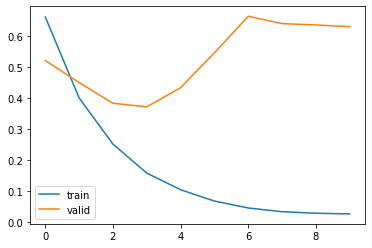

In [ ]:
pd.DataFrame(data={'train': train_losses, 'valid': valid_losses}).plot.line()

To solve this, we'll look at a couple techniques we can use.

# RNN Dropout

In this section, we'll introduce special flavors of dropout used specifically for RNNs. We'll use the functional package from PyTorch to facilitate some intermediate computation.

In [ ]:
import torch.nn.functional as F
import warnings

We'll write code for producing *dropout masks*, which will be multiplied to our matrices to zero out certain weights.

In [ ]:
# Credits to the contributors at fast.ai
def dropout_mask(x, sz, p):
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

We'll write a special dropout for RNN layers. This ensures that we consistently zero-out across a time-dimension.

In [ ]:
class RNNDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p=p

    def forward(self, x):
        if not self.training or self.p == 0.: 
            return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

We'll also introduce a variant of dropout for the embedding layer. This wraps around an existing embedding layer and zero out certain embedding weights during training.

In [ ]:
class EmbeddingDropout(nn.Module):
    def __init__(self, emb, embed_p):
        super(EmbeddingDropout, self).__init__()
        self.emb = emb
        self.embed_p = embed_p
        self.pad_idx = self.emb.padding_idx
        if self.pad_idx is None: self.pad_idx = -1

    def forward(self, words, scale=None):
        if self.training and self.embed_p != 0:
            size = (self.emb.weight.size(0),1)
            mask = dropout_mask(self.emb.weight.data, size, self.embed_p)
            masked_embed = (self.emb.weight * mask)
        else: 
            masked_embed = (self.emb.weight)
        if scale: 
            masked_embed.mul_(scale)
        out = F.embedding(words, masked_embed, self.pad_idx, self.emb.max_norm,
                          self.emb.norm_type, self.emb.scale_grad_by_freq, self.emb.sparse)
        return out

Our final classifier now looks like this.

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_sz, embedding_dim, hidden_dim, output_dim, bidirectional=False, 
                 n_layers=1, dropout=0.5, recur_dropout=0.3, embed_dropout=0.1, initrange=0.1, initialize=True):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_sz, embedding_dim)
        self.embedding_dp = EmbeddingDropout(self.embedding, embed_dropout)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, 
                           bidirectional=bidirectional, num_layers=n_layers, 
                           dropout=recur_dropout if n_layers > 1 else 0.0)
        self.fc1 = nn.Linear(hidden_dim * 2, output_dim) if bidirectional else nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn_dropout = RNNDropout(recur_dropout)

        if initialize: self.init_weights(initrange)

    def init_hidden(self, bs):
        weights = next(self.parameters())
        hidden_dim, n_layers = self.rnn.hidden_size, self.rnn.num_layers
        directions = 2 if self.rnn.bidirectional else 1

        hidden = weights.new_zeros(directions * n_layers, bs, hidden_dim)
        cell = weights.new_zeros(directions * n_layers, bs, hidden_dim)
        return hidden, cell

    def init_weights(self, initrange=0.1):
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        bs, msl = x.shape

        hidden, cell = self.init_hidden(bs)
        out = self.embedding_dp(x)
        out = self.rnn_dropout(out)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))

        if self.rnn.bidirectional:
            out = torch.cat([hidden[-2], hidden[-1]], 1)
        else: out = hidden[-1]

        out = self.dropout(out)
        out = self.fc1(out)
        return out

We'll instantiate our model. This time, we'll use AMSGrad as our optimizer, and introduce weight decay (L2 regularization).

In [ ]:
model = LSTMClassifier(vocab_sz=len(vocab_set), 
                       embedding_dim=100, 
                       hidden_dim=128, 
                       output_dim=2, 
                       dropout=0.65,
                       embed_dropout=0.1,
                       recur_dropout=0.65,
                       bidirectional=True,
                       n_layers=1,
                       initialize=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2, amsgrad=True)

epochs = 10
iters = epochs * len(train_loader)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=iters, eta_min=0)

print("The model has {:,} trainable parameters".format(count_parameters(model)))

The model has 5,846,834 trainable parameters


Train with the same settings.

In [ ]:
clip = 1.0
train_losses, valid_losses = [], []

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0
    
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    valid_loss, valid_acc = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            valid_loss += loss.item()
            valid_acc += accuracy(out, y)
    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print("\nEpoch {:3} | Train Loss {:.4f} | Train Acc {:.4f} | Valid Loss {:.4f} | Valid Acc {:.4f}".format(e, train_loss, train_acc, valid_loss, valid_acc))

  1%|          | 6/547 [00:00<00:09, 59.35it/s]


Epoch   1 | Train Loss 0.6939 | Train Acc 0.5012 | Valid Loss 0.6908 | Valid Acc 0.5339


  1%|          | 6/547 [00:00<00:09, 57.92it/s]


Epoch   2 | Train Loss 0.6138 | Train Acc 0.6642 | Valid Loss 0.5327 | Valid Acc 0.7523


  1%|          | 6/547 [00:00<00:09, 58.87it/s]


Epoch   3 | Train Loss 0.4631 | Train Acc 0.7962 | Valid Loss 0.3848 | Valid Acc 0.8344


  1%|          | 6/547 [00:00<00:09, 58.65it/s]


Epoch   4 | Train Loss 0.3817 | Train Acc 0.8424 | Valid Loss 0.3390 | Valid Acc 0.8602


  1%|          | 6/547 [00:00<00:09, 59.77it/s]


Epoch   5 | Train Loss 0.3293 | Train Acc 0.8703 | Valid Loss 0.3469 | Valid Acc 0.8535


  1%|          | 6/547 [00:00<00:09, 59.90it/s]


Epoch   6 | Train Loss 0.2974 | Train Acc 0.8841 | Valid Loss 0.3354 | Valid Acc 0.8683


  1%|▏         | 7/547 [00:00<00:08, 60.50it/s]


Epoch   7 | Train Loss 0.2712 | Train Acc 0.8964 | Valid Loss 0.3334 | Valid Acc 0.8657


  1%|          | 6/547 [00:00<00:09, 58.46it/s]


Epoch   8 | Train Loss 0.2620 | Train Acc 0.9003 | Valid Loss 0.3374 | Valid Acc 0.8652


  1%|          | 6/547 [00:00<00:09, 59.46it/s]


Epoch   9 | Train Loss 0.2547 | Train Acc 0.9024 | Valid Loss 0.3398 | Valid Acc 0.8655


100%|██████████| 235/235 [00:01<00:00, 160.02it/s]


Epoch  10 | Train Loss 0.2469 | Train Acc 0.9053 | Valid Loss 0.3368 | Valid Acc 0.8671


This time, we get better results.

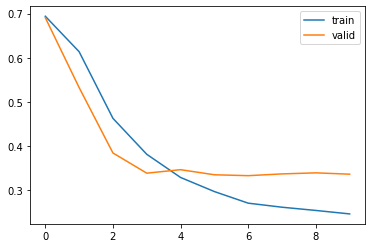

In [ ]:
pd.DataFrame(data={'train': train_losses, 'valid': valid_losses}).plot.line()

The problem with randomly-initialized embeddings is that the model spends a lot of time moving the embeddings to the correct places, before it learns to solve the task it is trying to learn. This makes learning unwieldy.

A solution to this is to use pretrained embeddings, which already contain syntactic information. This way, the model doesn't have to spend too much time adjusting, and training becomes smoother.

# Pretrained Embeddings

Let's download some pretrained GloVe embeddings.

GloVe is a method of training embeddings that uses corpus-wide co-occurence data to assign positions to each word. We'll discuss and implement this ourselves in a future lesson. For now, we'll use pretrained ones.

In [ ]:
#!wget https://s3.us-east-2.amazonaws.com/blaisecruz.com/embeddings/glove.6B.50d.txt

We'll load the vectors into a dictionary.

In [ ]:
with open('glove.6B.50d.txt', 'r') as f:
    glove = {}
    for line in f:
        l = line.strip().split()
        glove[l[0]] = [float(v) for v in l[1:]]

Here's the vectors for the word 'the'

In [ ]:
print(glove['the'])

[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0.044457, -0.49688, -0.17862, -0.00066023, -0.6566, 0.27843, -0.14767, -0.55677, 0.14658, -0.0095095, 0.011658, 0.10204, -0.12792, -0.8443, -0.12181, -0.016801, -0.33279, -0.1552, -0.23131, -0.19181, -1.8823, -0.76746, 0.099051, -0.42125, -0.19526, 4.0071, -0.18594, -0.52287, -0.31681, 0.00059213, 0.0074449, 0.17778, -0.15897, 0.012041, -0.054223, -0.29871, -0.15749, -0.34758, -0.045637, -0.44251, 0.18785, 0.0027849, -0.18411, -0.11514, -0.78581]


Let's use the vectors.

For every word in our vocabulary that exists in the vocabulary of GloVe, we'll use the trained embedding. Otherwise, we'll use a randomly initialized one.

In [ ]:
glove_vocab = set(glove.keys())

vectors = []
for token in idx2word:
    if token in glove_vocab: vectors.append(torch.FloatTensor(glove[token]))
    else: vectors.append(torch.rand(50).uniform_(-0.1, 0.1))

Here's an example word.

In [ ]:
idx2word[0]

'exacerbate'

And it's embedding.

In [ ]:
print(glove['exacerbate'])

[0.41817, -0.46122, 0.010667, -0.12624, -0.87323, 0.63934, 1.39, 0.426, -0.016501, -0.28983, 0.31326, 0.035407, -0.21225, -0.52607, 0.2903, 1.5516, 0.20275, -0.69439, 1.142, 0.014968, -0.32994, -0.95339, -0.012949, 0.33271, 0.17152, -0.12719, 0.28879, 0.1482, 1.3775, 1.2105, 0.8042, 1.1108, 0.41383, -0.77357, -0.73544, 0.11489, -1.1682, -0.96491, 0.167, 0.23047, -1.0953, 0.22614, 0.21805, 0.00060762, 0.55483, 0.48155, 0.76849, 0.82595, -0.18012, 0.17437]


Here's a sanity check to show that we copied it in the same index in the final vector matrix.

In [ ]:
print(vectors[0])

tensor([ 4.1817e-01, -4.6122e-01,  1.0667e-02, -1.2624e-01, -8.7323e-01,
         6.3934e-01,  1.3900e+00,  4.2600e-01, -1.6501e-02, -2.8983e-01,
         3.1326e-01,  3.5407e-02, -2.1225e-01, -5.2607e-01,  2.9030e-01,
         1.5516e+00,  2.0275e-01, -6.9439e-01,  1.1420e+00,  1.4968e-02,
        -3.2994e-01, -9.5339e-01, -1.2949e-02,  3.3271e-01,  1.7152e-01,
        -1.2719e-01,  2.8879e-01,  1.4820e-01,  1.3775e+00,  1.2105e+00,
         8.0420e-01,  1.1108e+00,  4.1383e-01, -7.7357e-01, -7.3544e-01,
         1.1489e-01, -1.1682e+00, -9.6491e-01,  1.6700e-01,  2.3047e-01,
        -1.0953e+00,  2.2614e-01,  2.1805e-01,  6.0762e-04,  5.5483e-01,
         4.8155e-01,  7.6849e-01,  8.2595e-01, -1.8012e-01,  1.7437e-01])


Finally, we'll turn this into a PyTorch tensor.

In [ ]:
pretrained_embeddings = torch.stack(vectors)
print(pretrained_embeddings.shape)

torch.Size([56108, 50])


# Putting Everything Together

Let's put everything together. Instantiate a model with less regularization.

In [ ]:
model = LSTMClassifier(vocab_sz=len(vocab_set), 
                       embedding_dim=50, 
                       hidden_dim=256, 
                       output_dim=2, 
                       dropout=0.5,
                       embed_dropout=0.1,
                       recur_dropout=0.4,
                       bidirectional=True,
                       n_layers=1)

We'll copy the vectors into our model.

In [ ]:
model.embedding_dp.emb.weight.data.copy_(pretrained_embeddings);
model.embedding_dp.emb.weight.requires_grad = True

And instantiate our setup. This time we'll train for a bit longer (20 epochs) and we won't use weight decay.

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, amsgrad=True)

epochs = 20
iters = epochs * len(train_loader)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=iters, eta_min=0)

print("The model has {:,} trainable parameters".format(count_parameters(model)))

The model has 3,437,210 trainable parameters


And train!

In [ ]:
clip = 1.0
train_losses, valid_losses = [], []

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0
    
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    valid_loss, valid_acc = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            valid_loss += loss.item()
            valid_acc += accuracy(out, y)
    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print("\nEpoch {:3} | Train Loss {:.4f} | Train Acc {:.4f} | Valid Loss {:.4f} | Valid Acc {:.4f}".format(e, train_loss, train_acc, valid_loss, valid_acc))

  1%|          | 5/547 [00:00<00:12, 43.05it/s]


Epoch   1 | Train Loss 0.6779 | Train Acc 0.5703 | Valid Loss 0.6167 | Valid Acc 0.6770


  1%|          | 5/547 [00:00<00:12, 42.39it/s]


Epoch   2 | Train Loss 0.6468 | Train Acc 0.6390 | Valid Loss 0.5984 | Valid Acc 0.7064


  1%|          | 5/547 [00:00<00:13, 41.67it/s]


Epoch   3 | Train Loss 0.6191 | Train Acc 0.6662 | Valid Loss 0.5992 | Valid Acc 0.6798


  1%|          | 5/547 [00:00<00:12, 43.08it/s]


Epoch   4 | Train Loss 0.5876 | Train Acc 0.6942 | Valid Loss 0.6085 | Valid Acc 0.7261


  1%|          | 5/547 [00:00<00:13, 41.18it/s]


Epoch   5 | Train Loss 0.5402 | Train Acc 0.7392 | Valid Loss 0.4865 | Valid Acc 0.7691


  1%|          | 5/547 [00:00<00:12, 43.62it/s]


Epoch   6 | Train Loss 0.5113 | Train Acc 0.7613 | Valid Loss 0.4537 | Valid Acc 0.7990


  1%|          | 5/547 [00:00<00:12, 41.88it/s]


Epoch   7 | Train Loss 0.4732 | Train Acc 0.7818 | Valid Loss 0.4389 | Valid Acc 0.8119


  1%|          | 5/547 [00:00<00:12, 42.51it/s]


Epoch   8 | Train Loss 0.4510 | Train Acc 0.7941 | Valid Loss 0.4494 | Valid Acc 0.8102


  1%|          | 5/547 [00:00<00:12, 42.78it/s]


Epoch   9 | Train Loss 0.4392 | Train Acc 0.8062 | Valid Loss 0.4125 | Valid Acc 0.8070


  1%|          | 5/547 [00:00<00:13, 41.53it/s]


Epoch  10 | Train Loss 0.4181 | Train Acc 0.8145 | Valid Loss 0.4623 | Valid Acc 0.7969


  1%|          | 5/547 [00:00<00:12, 42.77it/s]


Epoch  11 | Train Loss 0.4109 | Train Acc 0.8192 | Valid Loss 0.3766 | Valid Acc 0.8342


  1%|          | 5/547 [00:00<00:12, 42.01it/s]


Epoch  12 | Train Loss 0.4015 | Train Acc 0.8218 | Valid Loss 0.3827 | Valid Acc 0.8270


  1%|          | 5/547 [00:00<00:12, 43.70it/s]


Epoch  13 | Train Loss 0.3945 | Train Acc 0.8255 | Valid Loss 0.3850 | Valid Acc 0.8407


  1%|          | 5/547 [00:00<00:12, 43.38it/s]


Epoch  14 | Train Loss 0.3853 | Train Acc 0.8306 | Valid Loss 0.3949 | Valid Acc 0.8349


  1%|          | 5/547 [00:00<00:13, 41.68it/s]


Epoch  15 | Train Loss 0.3746 | Train Acc 0.8340 | Valid Loss 0.3681 | Valid Acc 0.8434


  1%|          | 5/547 [00:00<00:12, 42.97it/s]


Epoch  16 | Train Loss 0.3756 | Train Acc 0.8369 | Valid Loss 0.3730 | Valid Acc 0.8367


  1%|          | 5/547 [00:00<00:12, 42.36it/s]


Epoch  17 | Train Loss 0.3772 | Train Acc 0.8379 | Valid Loss 0.3865 | Valid Acc 0.8385


  1%|          | 5/547 [00:00<00:12, 42.05it/s]


Epoch  18 | Train Loss 0.3728 | Train Acc 0.8374 | Valid Loss 0.3785 | Valid Acc 0.8410


  1%|          | 5/547 [00:00<00:12, 43.08it/s]


Epoch  19 | Train Loss 0.3715 | Train Acc 0.8398 | Valid Loss 0.3777 | Valid Acc 0.8405


100%|██████████| 235/235 [00:01<00:00, 138.56it/s]


Epoch  20 | Train Loss 0.3732 | Train Acc 0.8389 | Valid Loss 0.3785 | Valid Acc 0.8397


This leads to more robust training.

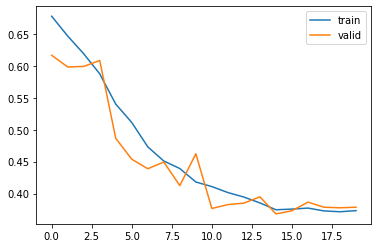

In [ ]:
pd.DataFrame(data={'train': train_losses, 'valid': valid_losses}).plot.line()